/global/cfs/cdirs/desi/survey/fiberassign/special/tertiary/0026  
https://data.desi.lbl.gov/desi/survey/fiberassign/special/tertiary/0026/  
/global/homes/r/raichoor/Scripts/laelbg-custom_healpix_coadds_prepare.py

In [179]:
tt = Table(fitsio.read('/global/cfs/cdirs/desi/survey/fiberassign/special/tertiary/0026/inputcats/COSMOS_LAE_Candidates_2023apr04v2.fits.gz'))
tt

RA,DEC,PMRA,PMDEC,SELECTION,PRIORITY,CANDTYPE
float64,float64,float64,float64,str79,int32,str29
150.5029562943439,1.6836337613351895,0.0,0.0,LAE N419 ODIN+HSC,9500,LAE N419
150.50623844740076,1.647820732789548,0.0,0.0,LAE N419 ODIN+HSC,9500,LAE N419
150.55223717448425,1.767879001718357,0.0,0.0,LAE N419 ODIN+HSC; LAE N419 ODIN+LSDR10,9500,LAE N419
150.5713755477888,1.7155518011299957,0.0,0.0,LAE N419 ODIN+HSC; LAE N419 ODIN+LSDR10,9500,LAE N419
150.58474270522711,1.724665817724438,0.0,0.0,LAE N419 ODIN+HSC,9500,LAE N419
150.58969783581938,1.6328673531019615,0.0,0.0,LAE N419 ODIN+HSC,9500,LAE N419
150.59401914848996,1.6260538562586644,0.0,0.0,LAE N419 ODIN+HSC,9500,LAE N419
150.59405284785223,1.8557182297391508,0.0,0.0,LAE N419 ODIN+HSC,9500,LAE N419
150.5970248442796,1.79533788537415,0.0,0.0,LAE N419 ODIN+HSC; LAE N419 ODIN+LSDR10,9500,LAE N419


In [180]:
ff = Table(fitsio.read('/pscratch/sd/d/dstn/suprime/forced-hsc-all/tractor-forced-1498p020.fits'))
ff

release,brickid,brickname,objid,brick_primary,maskbits,fitbits,type,ra,dec,ra_ivar,dec_ivar,bx,by,dchisq,ebv,mjd_min,mjd_max,ref_cat,ref_id,pmra,pmdec,parallax,pmra_ivar,pmdec_ivar,parallax_ivar,ref_epoch,gaia_phot_g_mean_mag,gaia_phot_g_mean_flux_over_error,gaia_phot_g_n_obs,gaia_phot_bp_mean_mag,gaia_phot_bp_mean_flux_over_error,gaia_phot_bp_n_obs,gaia_phot_rp_mean_mag,gaia_phot_rp_mean_flux_over_error,gaia_phot_rp_n_obs,gaia_phot_variable_flag,gaia_astrometric_excess_noise,gaia_astrometric_excess_noise_sig,gaia_astrometric_n_obs_al,gaia_astrometric_n_good_obs_al,gaia_astrometric_weight_al,gaia_duplicated_source,gaia_a_g_val,gaia_e_bp_min_rp_val,gaia_phot_bp_rp_excess_factor,gaia_astrometric_sigma5d_max,gaia_astrometric_params_solved,flux_i_a_l427,flux_i_a_l464,flux_i_a_l484,flux_i_a_l505,flux_i_a_l527,flux_ivar_i_a_l427,flux_ivar_i_a_l464,flux_ivar_i_a_l484,flux_ivar_i_a_l505,flux_ivar_i_a_l527,fiberflux_i_a_l427,fiberflux_i_a_l464,fiberflux_i_a_l484,fiberflux_i_a_l505,fiberflux_i_a_l527,fibertotflux_i_a_l427,fibertotflux_i_a_l464,fibertotflux_i_a_l484,fibertotflux_i_a_l505,fibertotflux_i_a_l527,apflux_i_a_l427,apflux_i_a_l464,apflux_i_a_l484,apflux_i_a_l505,apflux_i_a_l527,apflux_resid_i_a_l427,apflux_resid_i_a_l464,apflux_resid_i_a_l484,apflux_resid_i_a_l505,apflux_resid_i_a_l527,apflux_blobresid_i_a_l427,apflux_blobresid_i_a_l464,apflux_blobresid_i_a_l484,apflux_blobresid_i_a_l505,apflux_blobresid_i_a_l527,apflux_ivar_i_a_l427,apflux_ivar_i_a_l464,apflux_ivar_i_a_l484,apflux_ivar_i_a_l505,apflux_ivar_i_a_l527,apflux_masked_i_a_l427,apflux_masked_i_a_l464,apflux_masked_i_a_l484,apflux_masked_i_a_l505,apflux_masked_i_a_l527,nobs_i_a_l427,nobs_i_a_l464,nobs_i_a_l484,nobs_i_a_l505,nobs_i_a_l527,rchisq_i_a_l427,rchisq_i_a_l464,rchisq_i_a_l484,rchisq_i_a_l505,rchisq_i_a_l527,fracflux_i_a_l427,fracflux_i_a_l464,fracflux_i_a_l484,fracflux_i_a_l505,fracflux_i_a_l527,fracmasked_i_a_l427,fracmasked_i_a_l464,fracmasked_i_a_l484,fracmasked_i_a_l505,fracmasked_i_a_l527,fracin_i_a_l427,fracin_i_a_l464,fracin_i_a_l484,fracin_i_a_l505,fracin_i_a_l527,ngood_i_a_l427,ngood_i_a_l464,ngood_i_a_l484,ngood_i_a_l505,ngood_i_a_l527,anymask_i_a_l427,anymask_i_a_l464,anymask_i_a_l484,anymask_i_a_l505,anymask_i_a_l527,allmask_i_a_l427,allmask_i_a_l464,allmask_i_a_l484,allmask_i_a_l505,allmask_i_a_l527,psfsize_i_a_l427,psfsize_i_a_l464,psfsize_i_a_l484,psfsize_i_a_l505,psfsize_i_a_l527,psfdepth_i_a_l427,psfdepth_i_a_l464,psfdepth_i_a_l484,psfdepth_i_a_l505,psfdepth_i_a_l527,galdepth_i_a_l427,galdepth_i_a_l464,galdepth_i_a_l484,galdepth_i_a_l505,galdepth_i_a_l527,nea_i_a_l427,nea_i_a_l464,nea_i_a_l484,nea_i_a_l505,nea_i_a_l527,blob_nea_i_a_l427,blob_nea_i_a_l464,blob_nea_i_a_l484,blob_nea_i_a_l505,blob_nea_i_a_l527,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,forced_flux_g,forced_flux_ivar_g,forced_apflux_g,forced_apflux_ivar_g,forced_psfdepth_g,forced_galdepth_g,forced_nexp_g,forced_flux_i,forced_flux_ivar_i,forced_apflux_i,forced_apflux_ivar_i,forced_psfdepth_i,forced_galdepth_i,forced_nexp_i,forced_flux_i2,forced_flux_ivar_i2,forced_apflux_i2,forced_apflux_ivar_i2,forced_psfdepth_i2,forced_galdepth_i2,forced_nexp_i2,forced_flux_r,forced_flux_ivar_r,forced_apflux_r,forced_apflux_ivar_r,forced_psfdepth_r,forced_galdepth_r,forced_nexp_r,forced_flux_r2,forced_flux_ivar_r2,forced_apflux_r2,forced_apflux_ivar_r2,forced_psfdepth_r2,forced_galdepth_r2,forced_nexp_r2,forced_flux_z,forced_flux_ivar_z,forced_apflux_z,forced_apflux_ivar_z,forced_psfdepth_z,forced_galdepth_z,forced_nexp_z
int16,int32,str8,int32,bool,int32,int16,str3,float64,float64,float32,float32,float32,float32,float32[5],float32,float64,float64,str2,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int16,float32,float32,int16,bool,float32,float32,int16,int16,float32,bool,float32,float32,float32,float32,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float3

In [155]:
import os
import numpy as np
import fitsio
import matplotlib.pyplot as plt
from astropy.table import Table

import desispec.spectra
from desispec.io.spectra import read_spectra

from desigal.specutils.stack import stack_spectra
from fastspecfit.io import read_fastspecfit

from fastspecfit.util import TabulatedDESI
cosmo = TabulatedDESI()

%matplotlib inline

In [111]:
datadir = '/global/cfs/cdirs/desi/users/raichoor/laelbg/daily/healpix/tertiary26-thru20230416'
fastdir = '/global/cfs/cdirs/desi/users/ioannis/tertiary/tertiary26'

In [156]:
def read_data():
    mergefile = os.path.join(fastdir, 'fastspec-vi-tertiary26.fits')
    fast, meta, _, _ = read_fastspecfit(mergefile)

    vifile = os.path.join(fastdir, 'VI_dey_Subaru.fits.gz')
    vi = Table(fitsio.read(vifile))
    iqso = ['qso' in comment.lower() or 'agn' in comment.lower() for comment in vi['VI_COMMENT']]
    I = np.logical_not(iqso) * (vi['VI_QUALITY'] >=3) * (vi['VI_Z'] > 2.4) * (vi['VI_Z'] < 3.5)
    vi = vi[I]
    vi.rename_column('VI_TARGETID', 'TARGETID')
    
    # trim out the LBGs
    ilae = np.where(['lae' in comment.lower() for comment in vi['VI_COMMENT']])[0]
    vi = vi[ilae]
    
    I = np.hstack([np.where(fast['TARGETID'] == tid)[0] for tid in vi['TARGETID']])
    fast = fast[I]
    meta = meta[I]
    
    fast['LYALPHA_LUM'] = fast['LYALPHA_FLUX'] * 1e-17 * 4 * np.pi * (cosmo.luminosity_distance(fast['Z']) * 3.0856776e+24)**2
    
    return vi, meta, fast

vi, meta, fast = read_data()
vi

INFO:io.py:1736:read_fastspecfit: Read 545 object(s) from /global/cfs/cdirs/desi/users/ioannis/tertiary/tertiary26/fastspec-vi-tertiary26.fits


2023-07-11 21:12:37,442 desiutil.log.dlm58.info INFO : Read 545 object(s) from /global/cfs/cdirs/desi/users/ioannis/tertiary/tertiary26/fastspec-vi-tertiary26.fits


TARGETID,TILEID,SPEC_VERSION,REDROCK_VERSION,TEMPLATE_VERSION,REDROCK_SPECTYPE,REDROCK_Z,REDROCK_DELTACHI2,VI_SCANNER,VI_QUALITY,VI_ISSUE,VI_Z,VI_SPECTYPE,VI_COMMENT,RA,DEC,TERTIARY_TARGET,PRIORITY
int64,int32,str14,str13,str12,str6,float64,float64,str3,int16,str1,float64,str6,str120,float64,float64,str11,int16
39089837499745338,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,1.47,3.9,dey,3,,2.5353,GALAXY,LAE,149.89220289116628,1.6509854537065722,LAE_SUBARU,8000
39089837499745287,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,0.0896,1.2,dey,4,,2.4507,GALAXY,LAE,149.8669898121445,1.6774942523808365,LAE_SUBARU,8000
39089837499745286,0,0.57.0.dev7802,0.17.0.dev758,-1,QSO,2.4135,37.9,dey,4,,2.4166,GALAXY,LAE,149.82763488365626,1.6472517347095443,LAE_SUBARU,8000
39089837499745428,0,0.57.0.dev7802,0.17.0.dev758,-1,QSO,2.5032,47.7,dey,4,,2.5049,GALAXY,LAE,149.80000686039827,1.6134728512316263,LAE_SUBARU,8000
39089837499745334,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,0.1587,29.7,dey,4,,2.5531,GALAXY,LAE,149.78467077978559,1.7322851396288987,LAE_SUBARU,8000
39089837499745386,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,1.3607,2.4,dey,3,,2.4727,GALAXY,LAE,149.47262894182808,1.5334382810273257,LAE_SUBARU,8000
39089837499745384,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,1.3607,4.0,dey,4,,2.5281,GALAXY,LAE,149.4229000831741,1.5107486468920597,LAE_SUBARU,8000
39089837499745283,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,1.2927,1.0,dey,4,,2.4454,GALAXY,LAE,149.4702598586282,1.6076629936276436,LAE_SUBARU,8000
39089837499745439,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,0.7466,0.7,dey,3,,2.4824,GALAXY,LAE; Double peaked line; z for blue component,149.4986688716188,1.8341154929562375,LAE_SUBARU,8000


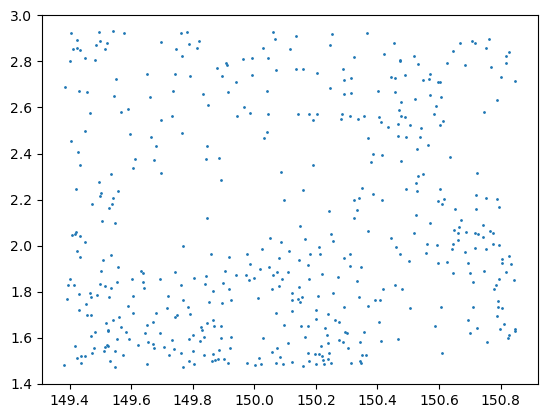

In [181]:
plt.scatter(meta['RA'], meta['DEC'], s=1)

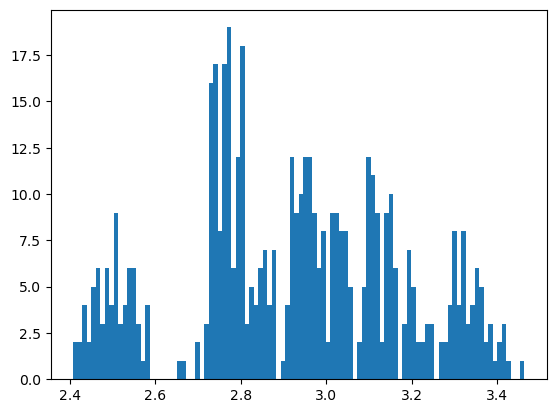

In [138]:
_ = plt.hist(meta['Z'], bins=100)

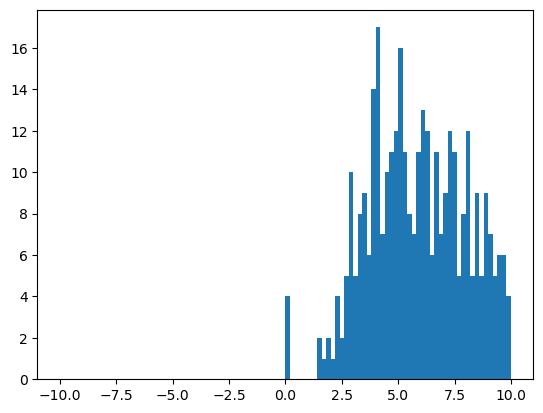

In [148]:
_ = plt.hist(fast['LYALPHA_FLUX'], bins=100, range=(-10, 10))
#plt.xlim(-100, 1000)

In [184]:
I = ['LBG' in comment for comment in vi['VI_COMMENT']]
vi[I]

TARGETID,TILEID,SPEC_VERSION,REDROCK_VERSION,TEMPLATE_VERSION,REDROCK_SPECTYPE,REDROCK_Z,REDROCK_DELTACHI2,VI_SCANNER,VI_QUALITY,VI_ISSUE,VI_Z,VI_SPECTYPE,VI_COMMENT,RA,DEC,TERTIARY_TARGET,PRIORITY
int64,int32,str14,str13,str12,str6,float64,float64,str3,int16,str1,float64,str6,str120,float64,float64,str11,int16
39089837499744861,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,1.4502,13.9,dey,4,,3.2032,GALAXY,LAE; LBG; z from Lya,149.8241467966105,1.5839302040469807,SUPRIME,8500
39089837499744723,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,1.2973,2.9,dey,3,,2.732,GALAXY,LAE LBG; double-peaked line; z from abspn,149.70764094357395,1.5610287904944338,SUPRIME,8500
39089837499744730,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,1.499,10.6,dey,4,,2.5643,GALAXY,LAE LBG,149.5279732708069,1.7752624817138511,SUPRIME,8500
39089837499744969,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,0.4472,2.7,dey,3,,2.51,GALAXY,LAE LBG,150.06064896917894,1.8717592879316078,SUPRIME,8500
39089837499744745,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,0.2523,35.8,dey,4,,2.8402,GALAXY,LAE LBG,149.69456464282413,1.855624563589278,SUPRIME,8500


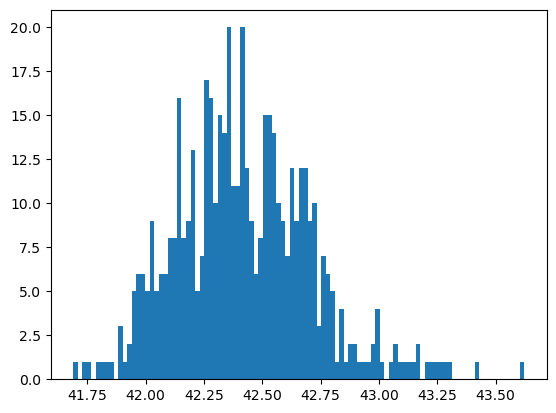

In [162]:
I = fast['LYALPHA_LUM'] > 0
_ = plt.hist(np.log10(fast['LYALPHA_LUM'][I]), bins=100)

In [163]:
vi[fast['LYALPHA_FLUX'] == 0.]['TARGETID', 'VI_COMMENT']

TARGETID,VI_COMMENT
int64,str120
39089837499745439,LAE; Double peaked line; z for blue component
39089837499745843,LAE
39089837499746072,LAE
39089837499744700,LAE


In [164]:
fast[fast['LYALPHA_FLUX'] == 0.]['HEALPIX', 'TARGETID', 'LYALPHA_FLUX', 'LYALPHA_EW']

HEALPIX,TARGETID,LYALPHA_FLUX,LYALPHA_EW
int32,int64,float32,float32
27247,39089837499745439,0.0,0.0
27245,39089837499745843,0.0,0.0
27247,39089837499746072,0.0,0.0
27344,39089837499744700,0.0,0.0


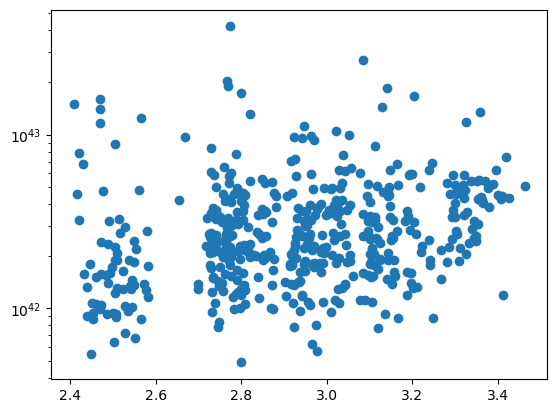

In [166]:
plt.scatter(fast['Z'], fast['LYALPHA_LUM'])
plt.yscale('log')
#plt.ylim(-100, 500)

In [167]:
minmax = np.array([3600, 9800, 0.8]) 
minmax / (1 + meta['Z'].min()), minmax / (1+meta['Z'].max())
minmax / (1 + 2.4), minmax / (1+3.5)

(array([1.05882353e+03, 2.88235294e+03, 2.35294118e-01]),
 array([8.00000000e+02, 2.17777778e+03, 1.77777778e-01]))

In [170]:
minwave, maxwave, dwave = 920., 2500., 0.05
gridwave = np.arange(minwave, maxwave+dwave, dwave)
gridwave

array([ 920.  ,  920.05,  920.1 , ..., 2499.95, 2500.  , 2500.05])

Stack everything

In [171]:
allspec = []
for healpix in sorted(set(meta['HEALPIX'])):
    mm = meta[meta['HEALPIX'] == healpix]    
    specfile = os.path.join(datadir, f'coadd-{healpix}.fits')
    spec = read_spectra(specfile).select(targets=mm['TARGETID'])
    allspec.append(spec)
allspec = desispec.spectra.stack(allspec)

INFO:spectra.py:291:read_spectra: iotime 3.889 sec to read coadd-27245.fits at 2023-07-11T21:42:59.166896


2023-07-11 21:42:59,166 desiutil.log.dlm58.info INFO : iotime 3.889 sec to read coadd-27245.fits at 2023-07-11T21:42:59.166896


INFO:spectra.py:291:read_spectra: iotime 2.556 sec to read coadd-27247.fits at 2023-07-11T21:43:03.743799


2023-07-11 21:43:03,743 desiutil.log.dlm58.info INFO : iotime 2.556 sec to read coadd-27247.fits at 2023-07-11T21:43:03.743799


INFO:spectra.py:291:read_spectra: iotime 1.760 sec to read coadd-27256.fits at 2023-07-11T21:43:07.170879


2023-07-11 21:43:07,170 desiutil.log.dlm58.info INFO : iotime 1.760 sec to read coadd-27256.fits at 2023-07-11T21:43:07.170879


INFO:spectra.py:291:read_spectra: iotime 7.678 sec to read coadd-27257.fits at 2023-07-11T21:43:16.295981


2023-07-11 21:43:16,296 desiutil.log.dlm58.info INFO : iotime 7.678 sec to read coadd-27257.fits at 2023-07-11T21:43:16.295981


INFO:spectra.py:291:read_spectra: iotime 4.989 sec to read coadd-27258.fits at 2023-07-11T21:43:23.258097


2023-07-11 21:43:23,258 desiutil.log.dlm58.info INFO : iotime 4.989 sec to read coadd-27258.fits at 2023-07-11T21:43:23.258097


INFO:spectra.py:291:read_spectra: iotime 2.201 sec to read coadd-27259.fits at 2023-07-11T21:43:26.840135


2023-07-11 21:43:26,840 desiutil.log.dlm58.info INFO : iotime 2.201 sec to read coadd-27259.fits at 2023-07-11T21:43:26.840135


INFO:spectra.py:291:read_spectra: iotime 4.450 sec to read coadd-27344.fits at 2023-07-11T21:43:32.909478


2023-07-11 21:43:32,909 desiutil.log.dlm58.info INFO : iotime 4.450 sec to read coadd-27344.fits at 2023-07-11T21:43:32.909478


In [176]:
srt = np.hstack([np.where(meta['TARGETID'] == tid)[0] for tid in allspec.fibermap['TARGETID']])
fast = fast[srt]
meta = meta[srt]
assert(np.all(meta['TARGETID'] == allspec.fibermap['TARGETID']))

In [173]:
(flux, ivar), wave = stack_spectra(allspec, redshift=meta['Z'], norm_method='flux-window', #"mean", "median", "flux-window"
                                   norm_flux_window=[1500, 1550], output_wave_grid=gridwave,
                                   resample_method='linear', # "linear", "sn-cons", "flux-cons"
                                   stack_method='ivar-weighted-mean', # median , mean
                                   n_workers=24, bootstrap=True)

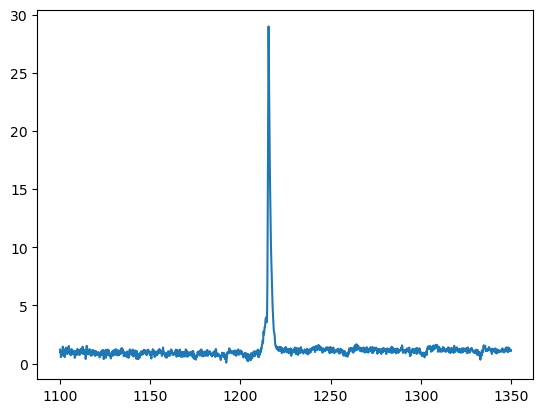

In [174]:
I = (wave > 1100) * (wave < 1350)
plt.plot(wave[I], flux[I])

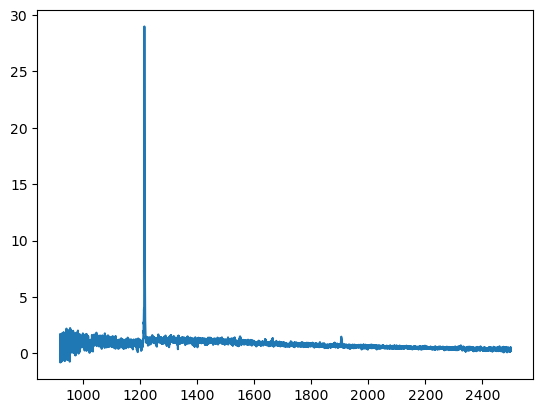

In [175]:
plt.plot(wave, flux)